
# Linear Regression Example
The example below uses a [marketing](https://scikit-learn.org/stable/datasets/toy_dataset.html) dataset,
in order to illustrate a linear regression activity.

Workflow:



1. Preparation
    1. Load the dataset from a `.csv` file and show a short description
    1. Show the two dimensional scatter plots for all the predicting variables with respect to the target
    1. Split the data into *predicting variables* `X` and *target* `y`
        1. here we set the `random_state` variable to make the experiment *repeatable* 
1. First experiment: compute the regression on a single predicting variable
    1. Consider a reduced dataset containing the chosen variable and the target
    1. Fit the `LinearRegression` estimator on the training set
    1. Show the statistical significance of the fitted model
    1. Predict the target for the test set using the *fitted* estimator
    1. Compute the regression coefficients and the quality measures: *Root Mean Squared Error (RMSE)* and *coefficient of determination (r2)*
1. Second experiment: compute the regression considering all the predicting variables
    1. Repeat the steps from 2.2 to 2.5
1. Third experiment: use the `DecisionTreeRegressor` with the entire dataset
    1. Fit the tree using the default hyperparameters, in order to find the 
    maximum depth of the unconstrained tree
    1. Use *cross-validation* to find the optimal *maximum depth* of the tree
    1. Fit the tree with the optmal `max_depth`
    1. Predict and show the *root mean squared error*
1. Fourth experiment: use the `RandomForestRegressor`
    1. Repeat steps from 4.2 to 4.4 (for simplicity, we use the maximum `max_depth` found in 4.1)


In [1]:
# Code source: Claudio Sartori 
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split

random_state = 94922767 # this will be used to guarantee the repeatability of the experiment

## Load the dataset from a `.xlsx` file and show a short description

In [2]:
# This cell allows full compatibility between execution in Google Colab and in local
try:
  import google.colab.files
  IN_COLAB = True
except:
  IN_COLAB = False
# from google.colab import files
if IN_COLAB:
    uploaded = files.upload()

In [3]:
# The file must be available in the same directory, 
# or uploaded in the Colab environment 
# in the execution of the previous cell
data_fn = 'FoodUK2014.xlsx'
df0 = pd.read_excel(data_fn)

## Data Exploration and preparation

##### Show a short description of the columns

In [4]:
df0.describe()

,hhsize,adults_n,children_n,totalexp,Year,income,AgeHRP,qmeat,qfish,qfv,xmeat,xfish,xfv,uvmeat,uvfish,uvfv
count,5114.000000,5114.000000,5114.000000,5114.000000,5114.0,5114.000000,5114.000000,4873.000000,3542.000000,5017.000000,4873.000000,3542.000000,5017.000000,4873.000000,3542.000000,5017.000000
mean,2.363707,1.841807,0.521901,519.898868,2014.0,679.542002,53.802698,10.475023,2.146960,25.727801,68.108342,19.635469,58.943391,7.072523,9.934257,2.508315
std,1.244704,0.743052,0.945622,411.543093,0.0,499.596175,16.187912,8.798118,2.034353,18.371345,57.347230,18.725096,44.751694,2.931651,5.485175,1.358023
min,1.000000,0.000000,0.000000,-246.916821,2014.0,0.000000,17.000000,0.086667,0.108333,0.060667,0.195000,0.000000,0.520000,0.357694,0.000000,0.159672
25%,1.000000,1.000000,0.000000,260.598783,2014.0,306.954000,41.000000,4.452500,0.866667,12.222167,29.141668,6.917083,27.148333,5.171614,5.979375,1.760525
50%,2.000000,2.000000,0.000000,426.977227,2014.0,548.086000,54.000000,8.374167,1.625000,22.245817,54.708336,13.736667,49.356667,6.575851,8.804690,2.254208
75%,3.000000,2.000000,1.000000,651.003763,2014.0,925.652500,67.000000,14.005333,2.816667,35.037167,90.480003,26.000000,78.281662,8.295746,12.520942,2.893561
max,9.000000,7.000000,7.000000,5859.877186,2014.0,2134.090000,80.000000,104.589333,41.348362,169.283829,803.465027,194.869995,480.024994,40.000000,46.315834,32.666668


##### Show the number of rows with nulls

It is computed subtracting the number of rows in the dataset without nulls from the original number of rows

In [5]:
df0.shape[0] - df0.dropna().shape[0]

1668

#### Drop rows with nulls

In [6]:
df = df0.dropna()
print(df.shape[0])

3446


##### Data transormation
- Convert the alphanumeric SexHRP into numeric 0 and 1
    - the `sklearn` machine learning procedures work only with numeric predicting
      attributes
- Generate two new columns as ratio of other columns
    - this is suggested by background information

In [7]:
df = df.replace({"SexHRP": {"Male": 1, "Female": 0}})
columns = ["qmeat_hhsize_ratio", "income_hhsize_ratio"]
df["qmeat_hhsize_ratio"] = df["qmeat"] / df["hhsize"]
df["income_hhsize_ratio"] = df["income"] / df["hhsize"]

##### Use only the columns that the experts consider interesting
This is suggested by background information

In [8]:
columns = ["adults_n", "children_n", "SexHRP","AgeHRP", 
           "qmeat_hhsize_ratio", "income_hhsize_ratio", "uvmeat"]
df_sel = df[columns]
df_sel.head()

,adults_n,children_n,SexHRP,AgeHRP,qmeat_hhsize_ratio,income_hhsize_ratio,uvmeat
1,2,2,1,38,1.511250,206.130000,8.813621
2,2,0,1,54,5.890083,135.962500,7.965790
4,3,0,1,64,4.285667,165.346667,5.726323
5,2,2,1,70,8.968250,66.632500,8.451528
7,3,0,1,64,4.079111,134.393333,5.904745


## Choose the target and split the data into *predicting variables* `X` and *target* `y`

In [9]:
target = "qmeat_hhsize_ratio"
Y = df_sel[target]
X = df_sel.drop(columns=target)

## Show the two dimensional scatter plots for all the predicting variables with respect to the target

In [10]:
ncols=3
import math
nrows = math.ceil((df.shape[1]-1)/ncols)
figwidth = ncols * 7
figheigth = nrows*5

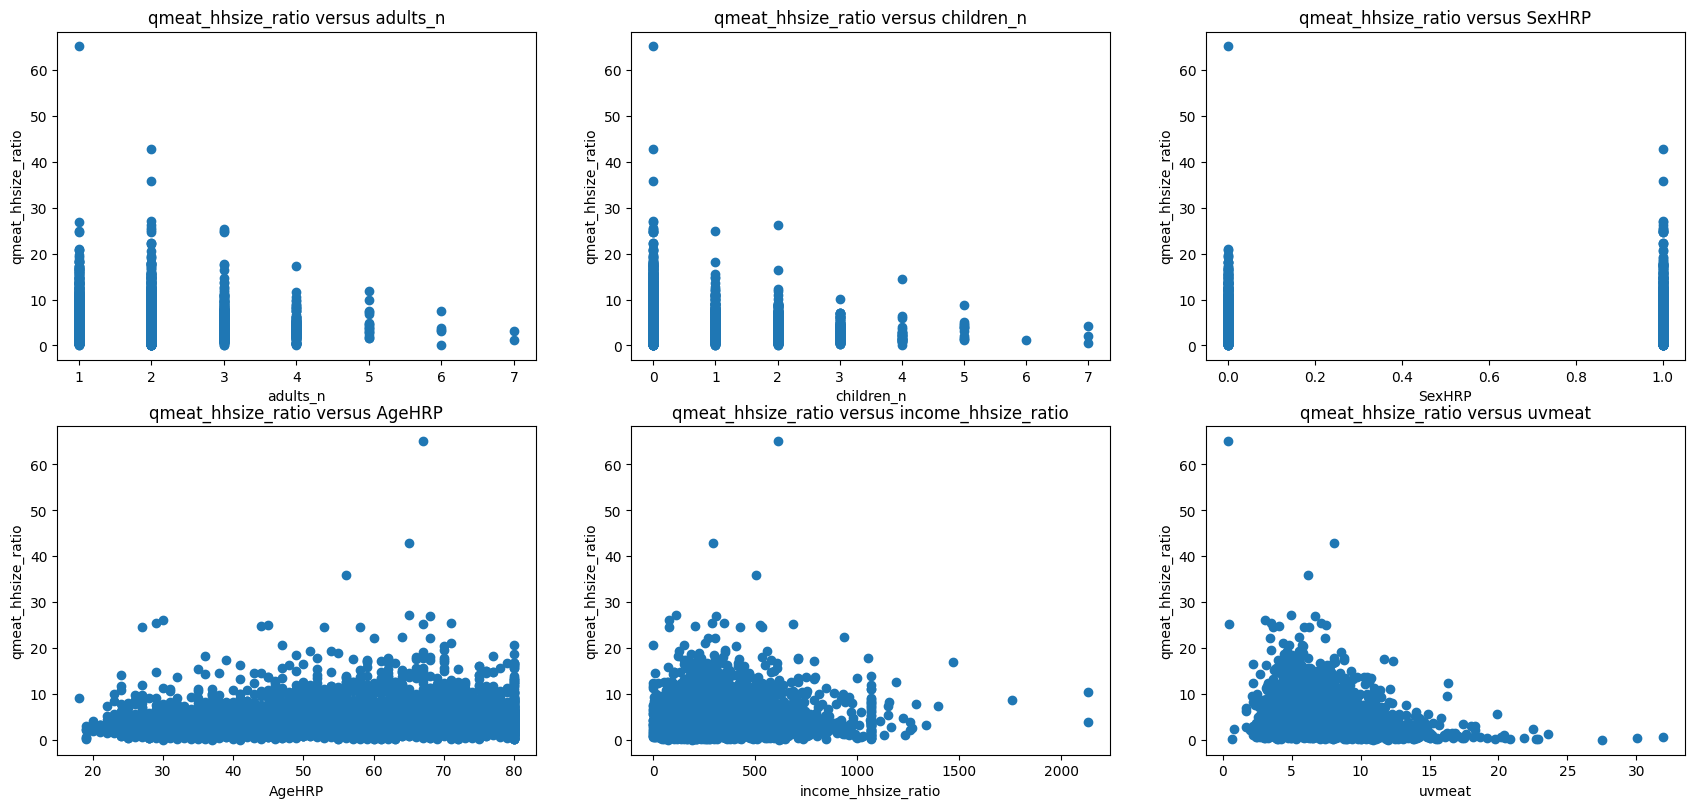

In [11]:
fig = plt.figure(figsize=(figwidth, figheigth))

k = 1
for col in X.columns:
    plt.subplot(nrows, ncols, k)
    plt.scatter(X[col], Y)
    plt.ylabel(target)
    plt.xlabel(col)
    plt.title(f"qmeat_hhsize_ratio versus {col}")
    k = k+1



### Show the *_p-values_* of the target with respect to the variables

In [13]:
from sklearn.feature_selection import f_regression
# Your code here
f_stat, p_values = f_regression(X, Y)

#for col, val in zip(list(X.columns), p_values):
#    print(f"Var: {col}\t{val}")
pd.DataFrame(data={"Variable": X.columns, "p-values": p_values})


,Variable,p-values
0,adults_n,1.415945e-05
1,children_n,1.077386e-30
2,SexHRP,8.429827e-02
3,AgeHRP,1.710126e-21
4,income_hhsize_ratio,1.211099e-03
5,uvmeat,4.789746e-52


## Split the data into *train* and *test* and show the sizes of the two parts
Here we set the `random_state` variable to make the experiment *repeatable*


In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=random_state)

### Consider a reduced dataset containing the chosen variable and the target

In [15]:
x_train.head()

,adults_n,children_n,SexHRP,AgeHRP,income_hhsize_ratio,uvmeat
4644,2,0,1,75,177.5450,4.020690
3423,2,0,0,43,611.9350,7.862123
3495,3,1,1,65,533.5225,2.424242
3624,2,0,1,69,208.9200,15.545454
4502,2,0,0,57,172.8600,8.579373


### Fit the `linear_model` estimator on the training set and predict the target for the test set using the *fitted* estimator

In [16]:
target_linear = "adults_n"
model =linear_model.LinearRegression()
model.fit(x_train[target_linear].values.reshape(-1, 1), y_train)
y_pred = model.predict(x_test[target_linear].values.reshape(-1, 1))


#### Compute the regression coefficients and the quality measures
Create a function to compute the F-statistic and p-value of the regression model

In [17]:
# Computation of F-statistic and p-value for the regression
# http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm
def stats(model, y, y_pred):
    p = len(model.get_params())
    intercept = model.intercept_
    coefficient = model.coef_   
    ssm = 0
    y_mean = np.mean(y)
    ssm = np.sum((y-y_mean)**2)
    mse = mean_squared_error(y, y_pred)
    dfm = p - 1
    # TODO - compute p-value
    p_value = 0
    if dfm > 0:
        print("DFS = 0")
        msm=0
        f_stat= 0
    else:
        msm = ssm/dfm
        f_stat = msm / mse
    return intercept, coefficient, np.sqrt(mse), r2_score(y, y_pred), msm, f_stat, p_value

values = stats(model, y_test, y_pred)
print(values)

DFS = 0
(5.728079312346098, array([-0.37965321]), 3.870578056926627, 0.005568505625079823, 0, 0, 0)


In [162]:
stats_name = ["Intercept for " + target_linear, "Coefficient for " +
              target_linear, "rmse", "r2", "f-statistic", "p-value"]
for name, val in zip(stats_name, values):
    print(f"{name}: \t\t{val}")

Intercept for adults_n: 		5.728079312346098
Coefficient for adults_n: 		[-0.37965321]
rmse: 		3.870578056926627
r2: 		0.005568505625079823
f-statistic: 		0
p-value: 		0


#### Compute the statistical significance of the model

,Univariate Linear - Value
"Intercept for ""adults_n""",5.646984
"Coefficient for ""adults_n""",-0.326893
rmse,3.886323
r2,0.007595
f-statistic,9.841162
p-value,0.001727


## Second experiment: compute the regression considering all the predicting variables

### Now we use the entire data in `X_train` and `X_test` for fitting and predicting

In [18]:
model_full = linear_model.LinearRegression()
model_full.fit(x_train, y_train)
y_pred = model_full.predict(x_test)

### Fit, predict and show the results
Now we see the *regression coefficients* resulting from the fitting. 

In particular, *positive coefficients* indicate that the target *increases* with the variable, *negative coefficients* indicate a *decreasing* trend.

The absolute values of the coefficient cannot be considered directly a measure of importance, due to the possibly different orders of magnitude of the data in the different columns (observe above the outputs of `describe`).

In [21]:
intercept, coefficients, rmse, r2, msm, f_stat, p_value = stats(model_full, y_test, y_pred)
print(coefficients)
out = pd.DataFrame({"Variable": list(X.columns), "p_value": coefficients})
out

DFS = 0
[-3.21975308e-01 -6.62542943e-01  2.47912608e-01  1.88911632e-02
  6.32144398e-04 -3.72937365e-01]


,Variable,p_value
0,adults_n,-0.321975
1,children_n,-0.662543
2,SexHRP,0.247913
3,AgeHRP,0.018891
4,income_hhsize_ratio,0.000632
5,uvmeat,-0.372937


#### Compute the statistical significance

,Variable,p-value
0,adults_n,4.812836e-19
1,children_n,1.384315e-188
2,SexHRP,5.806116e-10
3,AgeHRP,3.199609e-119
4,income_hhsize_ratio,6.460728e-08
5,uvmeat,0.000000e+00


#### Compute the quality measures

In [22]:
out = pd.DataFrame({"Variable": [
                   "rmse", "r2", "f-statistic", "p-value"], "value": [rmse, r2, f_stat, p_value]})
out


,Variable,value
0,rmse,3.651644
1,r2,0.114884
2,f-statistic,0.000000
3,p-value,0.000000


## Decision Tree Multivariate Regresson

In [23]:
# Create Decision Tree regression object
from sklearn.tree import DecisionTreeRegressor

#### Fit the tree with default hyperparameters, and find the maximum depth of the unconstrained tree

In [24]:
tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)
print(tree.get_depth())

33


#### Find the optimal value of the hyperparameter `max_depth` with *cross-validation*
The optimization searches for the *maximum tree depth* guaranteing the smallest mean squared error
At the end, this operation returns also the *fitted best tree* `best_estimator_`

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

tree_regressor = DecisionTreeRegressor()

fit_params = [{"max_depth": [1, 2, 3, 4]}]
tree_csv = GridSearchCV(tree_regressor, fit_params,
                        scoring="neg_root_mean_squared_error")
tree_csv.fit(x_train, y_train)
tree_csv.best_params_
#cross_val_score(tree, x_train, y_train, fit_params=fit_params)
best_estimator = tree_csv.best_estimator_
print("Best max_depth: ", best_estimator.max_depth)

Best max_depth:  3


In [36]:
print(-tree_csv.best_score_)

3.575014385704237


Decision Tree Regression - RMSE = 3.79


#### Show the tree

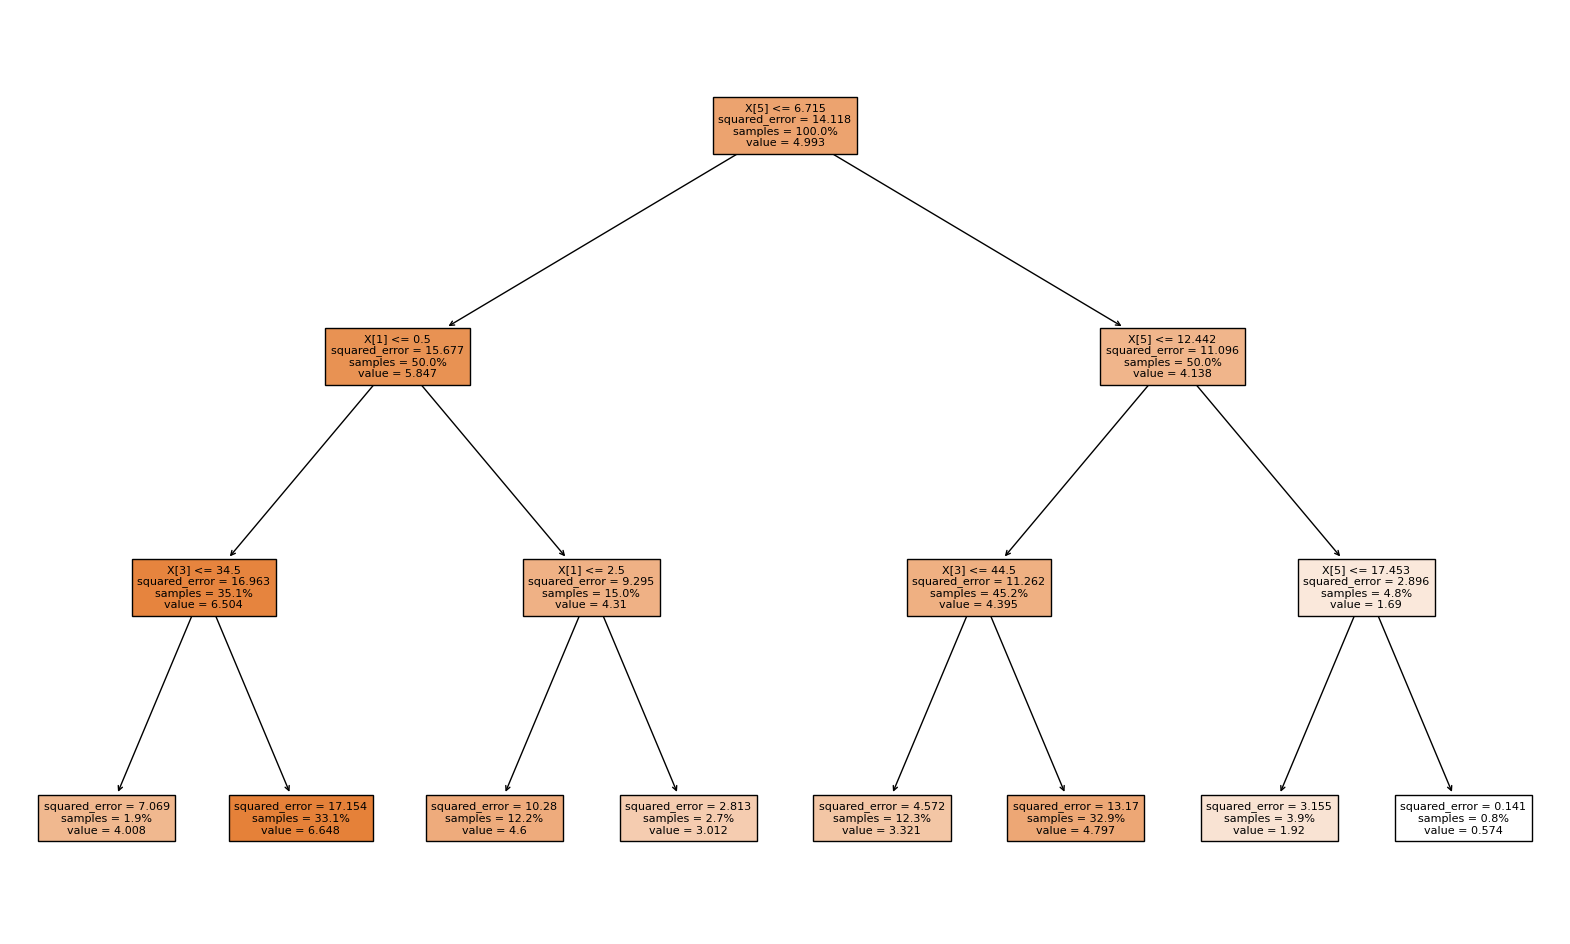

In [37]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure
# Your code here
plt.figure(figsize=(20, 12))  # set plot size (denoted in inches)
plot_tree(best_estimator, filled=True, proportion=True, fontsize=8);

## Random Forest Multivariate Regresson
Create a Random forest regressor and fit it on the complete dataset.

For simplicity use the max_depth found in the Decision tree regressor to perform a cross validation and find the best depth for this model.

In [38]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor()
forest.fit(x_train, y_train);

In [39]:
y_pred = forest.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

3.854058802856859

## Final observations
### Linear regression
The multivariate regression with all the predicting variables available with respect to the univariate regression has 
- lower RMSE 
- higher coefficient of determination 
- the p-value suggests the acceptance of both models
### Decision Tree and Random Forest regression
- Decistion Tree has an RMSE slightly higher than multivariate linear regression
- Random Forest has an RMSE slightly lower than multivariate linear regression


## Control questions
1. observing the multi-variate experiment, what variable has the higher effect on the target?
1. is there a variable having an almost negligible effect on the target?
1. try to repeat the univariate experiment with the other two columns and comment the results